# 🧠 Fine-Tuning a Pretrained Backbone

This notebook demonstrates how to **fine-tune a pretrained language model backbone** for a downstream NLP task.

### 🔍 Objective:
We'll take a **pretrained BERT model** and fine-tune it on a **sentiment analysis** dataset (e.g., IMDb, SST-2).

---

### 🧾 Key Concepts:

- **Pretrained Backbone (BERT)**  
  BERT is trained on a large corpus with masked language modeling and next sentence prediction, capturing general language representations.

- **Fine-Tuning**  
  We add a classification head to BERT and train it on a labeled dataset to adapt the model for **binary sentiment classification** (positive/negative).

- **Transfer Learning Benefit**  
  Fine-tuning allows us to retain the **language understanding** from pretraining while adapting to the **specific task**.

---

### 🛠️ What We'll Do:

1. Load a pretrained BERT model and tokenizer from Hugging Face
2. Prepare a sentiment analysis dataset (tokenization, batching)
3. Add a classification head to BERT
4. Fine-tune the model using a custom training loop or Trainer API
5. Evaluate the performance and visualize results

---

✅ Fine-tuning pretrained models is one of the most effective strategies in modern NLP, significantly improving performance on low-resource or task-specific datasets.


## 📂 Loading and Preparing the Dataset

In this section, we'll use the **IMDB movie reviews dataset** for binary sentiment classification.

### 🗃️ Dataset Details:
- 50,000 labeled movie reviews:
  - 25,000 for training
  - 25,000 for testing
- Labels:
  - `1` = Positive review
  - `0` = Negative review

---

### 🛠️ What We'll Do:

1. **Load the dataset** using `datasets.load_dataset("imdb")` from Hugging Face.
2. **Preprocess the text**:
   - Tokenize reviews using a BERT tokenizer
   - Truncate/pad sequences to a fixed length
3. **Format for training**:
   - Convert into `Dataset` objects compatible with PyTorch or TensorFlow
   - Create DataLoaders or tf.data pipelines for batching

---

✅ Once preprocessing is complete, we'll be ready to fine-tune BERT on this dataset for sentiment classification.


In [1]:
import tensorflow as tf
import keras_nlp
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Check versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras NLP version: {keras_nlp.__version__}")

# Load the IMDB dataset from tensorflow_datasets
train_ds, test_ds = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True,
    batch_size=32
)

# Check a sample from the dataset
for review_batch, label_batch in train_ds.take(1):
    for i in range(3):  # Print 3 examples
        print(f"Review: {review_batch[i].numpy().decode('utf-8')[:100]}...")
        print(f"Label: {'Positive' if label_batch[i].numpy() == 1 else 'Negative'}")
        print("-" * 50)

# Prepare the datasets - shuffle and cache for better performance
BUFFER_SIZE = 10000
train_ds = train_ds.shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

TensorFlow version: 2.18.0
Keras NLP version: 0.18.1


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RG4EWD_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RG4EWD_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RG4EWD_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. ...
Label: Negative
--------------------------------------------------
Review: I have been known to fall asleep during films, but this is usually due to a combination of things in...
Label: Negative
--------------------------------------------------
Review: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brenn...
Label: Negative
--------------------------------------------------


## 🧠 Fine-Tuning the Pretrained BERT Model

Now that we've prepared the IMDB dataset, we'll fine-tune a **pretrained BERT model** for sentiment classification.

---

### 📦 Model Choice:
We’ll use **BERT-tiny**, a lightweight variant of BERT that offers:
- Faster training
- Fewer parameters
- Reasonable performance on small tasks

✅ Despite its small size, it still benefits from **pretraining on large corpora**.

---

### 🛠️ What We'll Do:

1. **Load the Pretrained Model**  
   Use `AutoModelForSequenceClassification` with `bert-tiny`.

2. **Attach a Classification Head**  
   A simple linear layer for binary classification (positive/negative sentiment).

3. **Set Up Training Configuration**  
   - Optimizer (e.g., AdamW)  
   - Scheduler (optional)  
   - Loss function (CrossEntropyLoss)

4. **Train the Model**  
   Fine-tune BERT on the preprocessed IMDB dataset.

5. **Evaluate Performance**  
   Measure accuracy, precision, recall, and visualize confusion matrix.

---

### 📈 Why Fine-Tuning Works:

- Retains **language understanding** from pretraining
- Quickly adapts to task-specific patterns in the labeled data

✅ This approach is **cost-effective** and often outperforms training from scratch.


100%|██████████| 507/507 [00:00<00:00, 1.10MB/s]


Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 68ms/step - accuracy: 0.7323 - loss: 0.5096 - val_accuracy: 0.8772 - val_loss: 0.2950
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 55ms/step - accuracy: 0.9001 - loss: 0.2517 - val_accuracy: 0.8720 - val_loss: 0.3133
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.9392 - loss: 0.1668 - val_accuracy: 0.8820 - val_loss: 0.3121


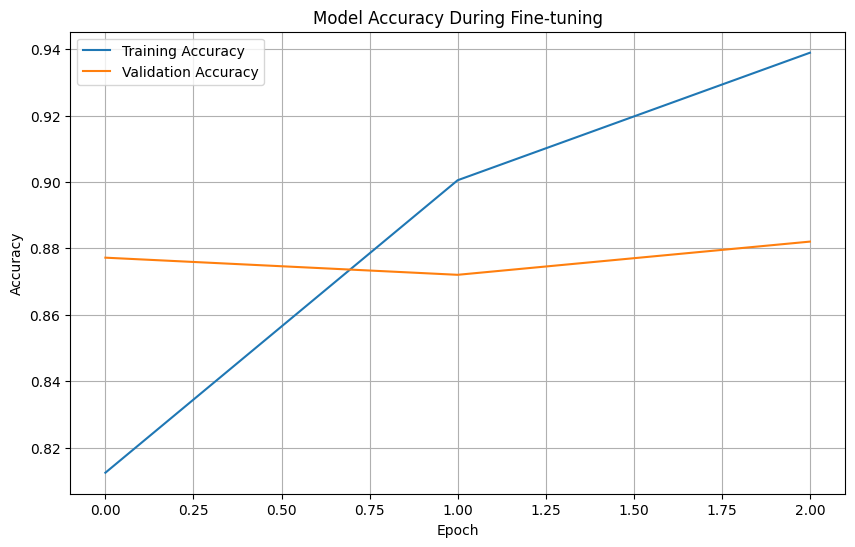

In [2]:
# Define preprocessing layer for BERT
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_tiny_en_uncased",
    sequence_length=512
)

# Load a pretrained BERT backbone for classification
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    preprocessor=preprocessor,
    num_classes=2
)

# Compile the model - we'll use a smaller learning rate for fine-tuning
classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Fine-tune the model - we'll use a smaller number of epochs for demonstration
history = classifier.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,  # You would use more epochs in a real scenario
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy During Fine-tuning")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

## ✅ Testing the Fine-Tuned Model

In this section, we'll evaluate our **fine-tuned BERT model** on **new, unseen examples** to test its sentiment classification performance.

---

### 🧪 What We'll Do:

1. **Load a few custom text samples** — both positive and negative reviews.
2. **Preprocess using the same tokenizer** used during training.
3. **Run inference** with the fine-tuned model.
4. **Interpret predictions** — `0` for negative, `1` for positive sentiment.

In [3]:
# Define some test examples
test_examples = [
    "This movie was simply amazing. The plot twists kept me engaged throughout.",
    "The acting was terrible and the dialogue was even worse. Complete waste of time.",
    "The cinematography was beautiful, but the pacing was too slow for my taste.",
    "I can't decide if I liked it or not, it had both good and bad moments."
]

# Predict using the fine-tuned model
predictions = classifier.predict(test_examples)
pred_classes = np.argmax(predictions, axis=1)

# Display results
for text, pred_class, pred in zip(test_examples, pred_classes, predictions):
    sentiment = "Positive" if pred_class == 1 else "Negative"
    confidence = tf.nn.softmax(pred)[pred_class].numpy()
    print(f"Text: {text}")
    print(f"Prediction: {sentiment} (Confidence: {confidence:.4f})")
    print("-" * 70)

# Evaluate on the test dataset
evaluation = classifier.evaluate(test_ds)
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Text: This movie was simply amazing. The plot twists kept me engaged throughout.
Prediction: Positive (Confidence: 0.9946)
----------------------------------------------------------------------
Text: The acting was terrible and the dialogue was even worse. Complete waste of time.
Prediction: Negative (Confidence: 0.9937)
----------------------------------------------------------------------
Text: The cinematography was beautiful, but the pacing was too slow for my taste.
Prediction: Negative (Confidence: 0.9884)
----------------------------------------------------------------------
Text: I can't decide if I liked it or not, it had both good and bad moments.
Prediction: Positive (Confidence: 0.8349)
----------------------------------------------------------------------
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8807 - loss: 0.3181
Test Loss: 0.3121
Test Accuracy: 0.8820
